In [1]:
import math 
import exodata
import pandas as pd 
import numpy as np 
import seaborn as sns 
import missingno as msno

In [2]:
from scipy.stats import norm
from random import randrange
from astropy import units as u
from mw_plot import MWPlot, MWSkyMap
from mpl_toolkits import mplot3d
from astropy.coordinates import SkyCoord  
from astropy.coordinates import ICRS, Galactic, FK4, FK5  
from astropy.coordinates import Angle, Latitude, Longitude 
from imblearn.over_sampling import SMOTE

In [3]:
import matplotlib.pyplot as plt
import exodata.astroquantities as aq
from IPython.display import display
from mlxtend.plotting import plot_confusion_matrix

In [4]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, f1_score, r2_score

In [5]:
import matplotlib as mpl
import matplotlib.patches as mpatches

In [6]:
%matplotlib inline
mpl.rcParams['lines.color'] = '#8B0000'
mpl.rcParams['text.color'] = '#8B0000'
mpl.rcParams['xtick.color'] = '#8B0000'
mpl.rcParams['ytick.color'] = '#8B0000'

In [7]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
def printscores(y_test, y_hat_test, X_test, y_train, y_hat_train, X_train, model):
    """Uses sklearn.metrics to compute & print the testing and training scores for your model. 
    Results include: Accuracy, Precision, Recall, F1, Residual Counts, 
    Residual Percentage Correct, CV Accuracy With Standard Deviation & R^2"""
    print('_____________________________________________________')
    print('Training Accuracy Score : ' + str(accuracy_score(y_train, y_hat_train).round(4) * 100)[:5] + '%')
    print('Training Precision Score : ' + str(precision_score(y_train, y_hat_train).round(4) * 100)[:5] + '%')
    print('Training Recall Score : ' + str(recall_score(y_train, y_hat_train).round(4) * 100)[:5] + '%')
    print('Training F1 Score : ' + str(f1_score(y_train, y_hat_train).round(4) * 100)[:5] + '%')
    print('_____________________________________________________')
    trainresiduals = np.abs(y_train - y_hat_train)
    print('Training residual count:')
    print(str(pd.Series(trainresiduals).value_counts())[:-29])
    print('Training percentage correct: ' + str(pd.Series(trainresiduals).value_counts(normalize=True).round(4)*100)[7:-45])
    print('_____________________________________________________')
    print('Testing Accuracy Score : ' + str(accuracy_score(y_test, y_hat_test).round(4) * 100)[:5] + '%')
    print('Testing Precision Score : ' + str(precision_score(y_test, y_hat_test).round(4) * 100)[:5] + '%')
    print('Testing Recall Score : ' + str(recall_score(y_test, y_hat_test).round(4) * 100)[:5] + '%')
    print('Testing F1 Score : ' + str(f1_score(y_test, y_hat_test).round(4) * 100)[:5] + '%')
    print('_____________________________________________________')
    testresiduals = np.abs(y_test - y_hat_test)
    print('Testing residual count:')
    print(str(pd.Series(testresiduals).value_counts())[:-29])
    print('Testing percentage correct: ' + str(pd.Series(testresiduals).value_counts(normalize=True).round(4)*100)[7:-45])
    print('_____________________________________________________')
    print('                                                     ')
    print('Cross validated model accuracy:')
    print('Testing:')
    scores = cross_val_score(model, X_test, y_test, cv=5)
    print('%0.2f with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
    print('Training:')
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print('%0.2f with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
    print('_____________________________________________________')
    r2_scoretst = r2_score(y_test, y_hat_test)
    print(f'Testing R2 Score: {r2_scoretst}')
    r2_scoretrn = r2_score(y_train, y_hat_train)
    print(f'Testing R2 Score: {r2_scoretrn}')    

In [9]:
def showheatmap(data):
    """Pass in your dataframe & it will plot you a large .corr() heatmap with all of your variables"""
    fig, ax = plt.subplots(figsize=(20,20))
    corr = data.corr().abs().round(3)
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    sns.heatmap(corr, annot=False, mask=mask, cmap='YlOrRd', ax=ax)
    plt.setp(ax.get_xticklabels(), 
             rotation=45, 
             ha="right",
             rotation_mode="anchor")
    ax.set_title('Correlations')
    fig.tight_layout()

In [10]:
def printVIF(data):
    """Pass in your dataframe & it will print your VIF scores for each column"""
    # empty VIF dataframe 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = data.columns 

    # calculate VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) 
                              for i in range(len(data.columns))] 
    print(vif_data)

In [11]:
def isnumber(s):
    """Checks if given value is a numer & if so returns false instead of value error"""
    try:
        float(s)
        return True
    except ValueError:
        return False

In [12]:
def showconfusionmatrix(y_t, y_hat_t, title):
    """Plots confusion matrix for provided y_train, y_hat_train OR y_test, y_hat_test """
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_t, y_hat_t), colorbar=True, show_absolute=True, show_normed=True, cmap='YlOrRd')
    ax.set_title(f'{title} Data')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['True', 'False'])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['True', 'False'])
    ax.set_ylabel('Actual Data')
    ax.set_xlabel('Predicted Data')
    plt.show()

In [13]:
def printreports(y_test, y_hat_test, y_train, y_hat_train):
    """Provided all input & predicted y values, prints classification report for training and testing data right next to each other"""
    print('                                                      ')
    print('               Testing Report:')
    report1 = classification_report(y_test, y_hat_test)
    print(report1)
    print('_____________________________________________________')
    print('               Training Report:')
    report2 = classification_report(y_train, y_hat_train)
    print(report2)
    print('_____________________________________________________')

In [14]:
def showstar(star, zoom):
    """Given star as star_csv.loc[your star] & zoom, either 'in' or 'out' plots your star compared with all of the other
    stars in our datasets on a map of the milky way. Both 'out' and 'in' are calculated based off of the stars distance
    from the sun (middle of the map) & should zoom and alter marker sizes accordingly. 
    Stars can be searched for by gl, hd, hip, comp_id, or proper name through stars.loc[star['search_column'] == 'for name']"""
    if zoom == 'out':
        radius = (star['dist']/10)*.5
        starra = Longitude(star['ra'], unit=u.deg)
        stardec = np.array(star['dec']) * u.deg
        stardist = np.array(star['dist']) * u.pc
        v =  SkyCoord(ra=starra, dec=stardec, distance=stardist, obstime='2001-01-01T12:00:00')
        plot_instance = MWPlot(mode='face-on', center=(0, 0)*u.kpc, radius=radius*u.kpc, unit=u.kpc, coord='galactic', annotation=False, rot180=False, grayscale=True)
        plot_instance.dpi = 200
        plot_instance.clim = (5., 15.)
        plot_instance.imalpha = .5
        plot_instance.s = radius/2
        plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                                 c='y')
        plot_instance.s = radius/2
        plot_instance.mw_scatter(-p.galactic.cartesian.x, p.galactic.cartesian.y,
                                 c='r')
        plot_instance.s = float(star['dist']/2)
        plot_instance.mw_scatter(-v.galactic.cartesian.x, v.galactic.cartesian.y,
                                 c='g')
        plt.show()
    elif zoom == 'in':
        radius = (star['dist']/10)*.01
        starra = Longitude(star['ra'], unit=u.deg)
        stardec = np.array(star['dec']) * u.deg
        stardist = np.array(star['dist']) * u.pc
        v =  SkyCoord(ra=starra, dec=stardec, distance=stardist, obstime='2001-01-01T12:00:00')
        plot_instance = MWPlot(mode='face-on', center=(0, 0)*u.kpc, radius=radius*u.kpc, unit=u.kpc, coord='galactic', annotation=False, rot180=False, grayscale=True)
        plot_instance.dpi = 200
        plot_instance.clim = (5., 15.)
        plot_instance.imalpha = .5
        plot_instance.s = star['dist']/20
        plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                                 c='y')
        plot_instance.s = star['dist']/20
        plot_instance.mw_scatter(-p.galactic.cartesian.x, p.galactic.cartesian.y,
                                 c='r')
        plot_instance.s = star['dist']*2.5
        plot_instance.mw_scatter(-v.galactic.cartesian.x, v.galactic.cartesian.y,
                                 c='g')
        plt.show()

In [15]:
def predict_a_star(star):
    """Test if a star in the hyg dataset will have a planet!
    pass in the star.loc[index_to_check] & answer some questions & the model will give you a yes or no!
    Stars can be searched for by gl, hd, hip, comp_id, or proper name through stars.loc[star['search_column'] == 'for name']"""
    print('Your star type is: ' + star.spect)
    nan = star_csv.hd[0].astype(str)
    if star.proper is np.nan:
        if star.gl is np.nan:
            if star.hd.astype(str) == nan:
                if star.hr.astype(str) == nan:
                    if star.hip.astype(str) == nan:
                        starname = ''
                    else:
                        starname = f'HIP {star.hip}'
                else:
                    starname = f'HR {star.hr}'
            else:
                starname = f'HD {star.hd}'
        else:
            starname = f'GL {star.gl}'
    else:
        starname = f'Proper Name: {star.proper} '
    s = star.to_frame().transpose().reset_index()
    print('_____________________________________________________________________________________________')
    print('                     ')
    print('Please answer a few questions to help the program understand your star type.')
    empty_frame = X.head(1)
    for column in empty_frame.columns:
        empty_frame.at[0, column] = 0
    norms = ['dist', 'absmag', 'lum']
    for col in norms:
        empty_frame.at[0, col] = (s.at[0, col] - min(star_csv[col]))/ (max(star_csv[col]) - min(star_csv[col])) 
    emptyframe = empty_frame.fillna(0.0)
    print('_____________________________________________________________________________________________')
    print('                     ')
    print('Does the type contain any capitalized letters? Please list all applicable seperated by spaces.')
    print('Please do not include roman numerals, we will handle those seperatly.')
    input4 = input()    
    letters = [ 'B', 'C', 'F', 'G', 'K', 'M', 'RD', 'W', 'O', 'D']
    if input4 == '':
        pass 
    else: 
        input4 = input4.strip().upper().split()
        for item in input4:
            if item in letters:
                if item == 'R':
                    item = 'RD'
                empty_frame.at[0, f'{item}'] = 1
            else:
                continue
    print('_____________________________________________________________________________________________')
    print('                 ')
    print('Does it contain numbers? Please list all applicable seperated by spaces')
    input2 = input()
    if input2 == '':
        pass
    else:
        list_ = input2.split()
        for item in list_:
            if isnumber(item):
                item = float(item)
                item = math.floor(item)
                empty_frame.at[0, f'{item}'] = 1
    print('_____________________________________________________________________________________________')
    print('                 ')
    print('Does it contain roman numerals? Please list all applicable seperated by spaces')
    lum_types = ['I', 'II', 'III', 'IV', 'V', 'VI']
    input1 = input()
    if input1 == '':
        pass 
    else: 
        input1 = input1.strip().upper()
        input1 = input1.split()
    for item in input1:
        if item in lum_types:
            empty_frame.at[0, item] = 1
    print('_____________________________________________________________________________________________')
    print('                 ')
    print('Does it contain any lowcase letters? Please list all applicable seperated by spaces.')
    input5 = input()
    lowerletters = [ 'sd', 'n', 'e', 'p', 'm']
    if input5 == '':
        pass 
    else: 
        input5 = input5.split()
        for item in input5:
            item = item.lower()
            if item in lowerletters:
                if item == 's':
                    item = 'sd'
                empty_frame.at[0, f'{item}'] = 1
            else:
                continue
    print('_____________________________________________________________________________________________')
    print('                     ')
    print('Does it contain any special symbols? Please list all applicable seperated by spaces.')
    print('Please substitute 1 in place of "...", 2 in place of "+", and 3  in place of ":"')
    input3 = input()
    if input3 == '':
        pass
    else:
        list_ = input3.strip().split()
        for item in list_:
            if  item == '1':
                col = '...'
                empty_frame.at[0, col] = 1
            elif item == '2':
                col = '+'
                empty_frame.at[0, col] = 1
            elif item == '3':
                col = ':'
                empty_frame.at[0, col] = 1
    print('Thank you for answering.')
    if final_model.predict(empty_frame)[0] == 1:
        print(' ')
        print(f'Your star, {starname} is unlikely to have a planet. :(')
    if final_model.predict(empty_frame)[0] == 0:
        print(' ')
        print(f'Your star, {starname} is likely to have a planet. :)')
    return empty_frame.copy() 

In [16]:
def plotall(radius, annotation, grayscale, dpi, imalpha, s1, s2, s3):
    """Plots all of your stars & the sun on a map of the milky way.
    Radius controls how far out you zoom from the center point (our sun)
    Annotation controls wether the galaxy is labeled or not, False reccomended if radius <4
    Grayscale controls if your map has color, False reccomended if radius <4
    DPI is the resolution & size of your image
    Imalpha controls how transparent your background is, it gets pretty pixelated as you zoom
    so I recommend making the background more transparent the closer to the sun you get
    s1, s2 & s3 are the sizes of your 3 sets of dots
    s1 is for the 100,000+ stars in star_csv
    s2 is for the 1,000 stars with planets
    s3 is for our sun"""
    plot_instance = MWPlot(mode='face-on', center=(0, 0)*u.kpc, radius=radius*u.kpc, unit=u.kpc, coord='galactic', annotation=annotation, rot180=False, grayscale=grayscale)
    plot_instance.dpi = dpi
    plot_instance.imalpha = imalpha
    plot_instance.s = s1
    plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                             c='y')
    plot_instance.s = s2
    plot_instance.mw_scatter(-p.galactic.cartesian.x, p.galactic.cartesian.y,
                             c='r')
    plot_instance.s = s3 
    plot_instance.mw_scatter(-s.galactic.cartesian.x, s.galactic.cartesian.y,
                             c='g')
    plt.show()

In [17]:
def getbestlogparams(X_train, y_train):
    """Given X_train & y_train, preforms gridsearch & returns best logistic regression parameters"""
    # Create pipe
    pipe = Pipeline([('classifier' , LogisticRegression())])
    # Populate grid
    param_grid = [
        {'classifier' : [LogisticRegression(max_iter=500)],
         'classifier__penalty' : ['l1', 'l2'],
         'classifier__C' : np.logspace(-4, 4, 20),
         'classifier__fit_intercept' : [True, False],
         'classifier__solver' : ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']}]

    # Create grid search object
    clf = GridSearchCV(pipe, param_grid, cv=10, estimator='recall',  n_jobs=-1)

    # Fit on data
    best_clf = clf.fit(X_train, y_train)
    list_ = [x for x in best_clf.best_params_.values()]
    return list_[0]

In [18]:
def show_roc_plot(fpr, tpr):
    """Given false positive rate & true positive rate, 
    plots & labels ROC, prints AUC above visual"""
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [19]:
# https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

## Import Data

In [20]:
data = pd.read_csv('scrubbed.csv', dtype=float)
data = data.drop(['Unnamed: 0', 'HE', 'NEP', 'CE', 'CN', 'CJ', 'HN', 'HSE', 'JUP', 'SE', 'WJ', 'WN', 'WSE', 'A'], 1)

In [21]:
#drop incorrectly calculated distances & outliers
data = data.loc[data['dist'] < 100000]
data = data.loc[data['children'] < 8]

In [22]:
data['absmag'].std()

2.856569269009928

## Explore Data

In [23]:
# Starting with a VIF, so I can be sure to get rid of any columns with high multicolinearity, we can already see a number of issues 
printVIF(data)

C:\ProgramData\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         feature           VIF
0       children  2.019875e+00
1             ra  1.801440e+15
2            dec           inf
3           dist  4.829005e+00
4           pmra  1.061210e+09
5          pmdec  3.027142e+07
6             rv  1.056061e+00
7            mag  3.473090e+01
8         absmag  7.624755e+00
9             ci  1.881491e+01
10             x  3.413594e+00
11             y  1.932923e+00
12             z  1.617226e+00
13            vx  3.728226e+00
14            vy  1.888009e+00
15            vz  3.978515e+00
16         rarad  1.801440e+15
17        decrad           inf
18       pmrarad           inf
19      pmdecrad  2.373063e+11
20  comp_primary  1.283247e+02
21           lum  1.631055e+00
22             I  1.136104e+00
23            II  1.077774e+00
24           III  2.361380e+00
25            IV  1.273903e+00
26             V  2.366879e+00
27            VI  1.253379e+00
28           ...  1.465253e+00
29             :  1.101403e+00
30             +  1.284030e+00
31      

C:\ProgramData\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


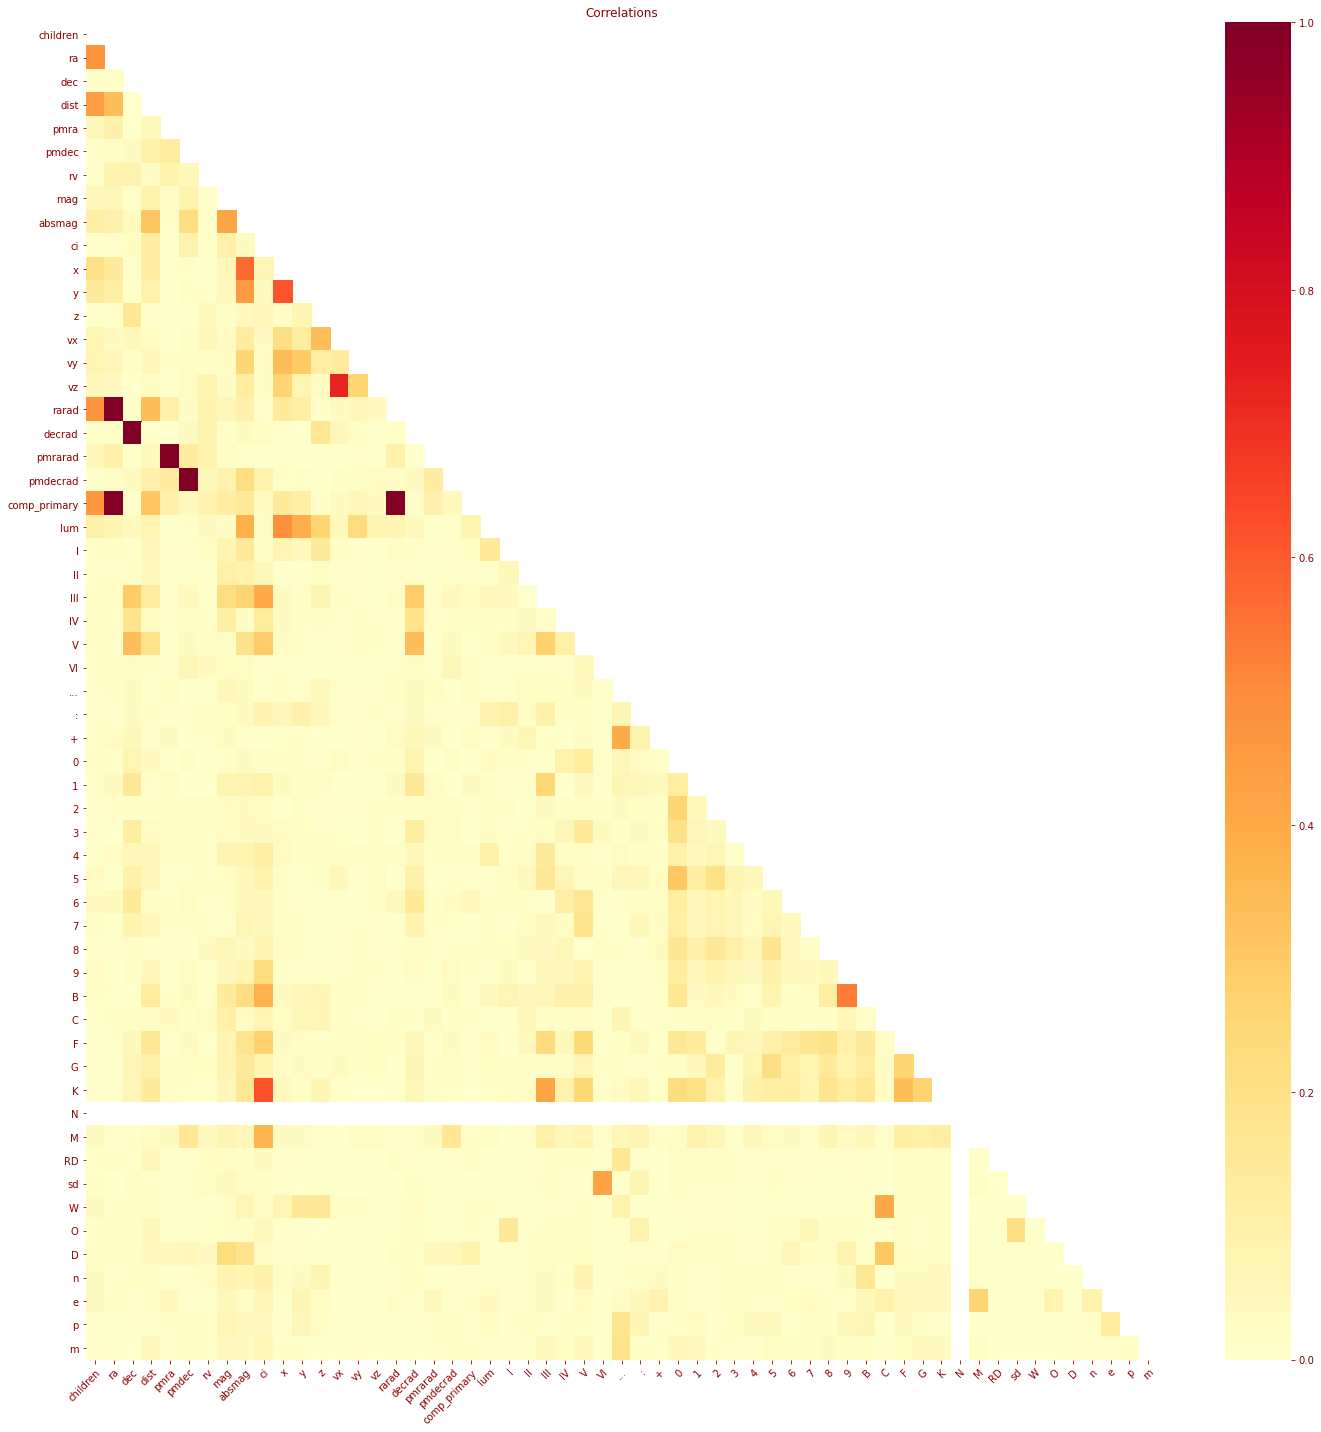

In [24]:
# Now we have some idea of what to start dropping from our dataframe, but we should also check for correlations
# in heatmaps, because issues with the data don't nessecarily all show up on one method or the other 
showheatmap(data)

In [25]:
# Get rid of all of our problem columns & test VIF & corr() again, if they're both clear proceed, if not, keep dropping until 
# corr() are all under .6 and VIF are all under 5 
data = data.drop(['vy', 'vz', 'vx', 'pmra', 'pmdec','rarad', 'decrad','pmrarad', 'pmdecrad', 'x', 'y', 'z', 'N', 'dec',
                  'comp_primary', 'ra', 'mag', 'ci', 'rv'], 1)
printVIF(data)

     feature       VIF
0   children  1.566536
1       dist  2.614801
2     absmag  2.183821
3        lum  1.257221
4          I  1.096181
5         II  1.054848
6        III  1.933300
7         IV  1.187279
8          V  1.928269
9         VI  1.245466
10       ...  1.429330
11         :  1.087849
12         +  1.267946
13         0  3.200272
14         1  1.622114
15         2  2.055713
16         3  1.654699
17         4  1.257352
18         5  2.733191
19         6  1.473700
20         7  1.370110
21         8  2.370347
22         9  1.824411
23         B  2.058586
24         C  1.400901
25         F  3.025032
26         G  2.691493
27         K  3.278408
28         M  1.441790
29        RD  1.043007
30        sd  1.311779
31         W  1.245804
32         O  1.122525
33         D  1.213675
34         n  1.061130
35         e  1.167757
36         p  1.091443
37         m  1.076750


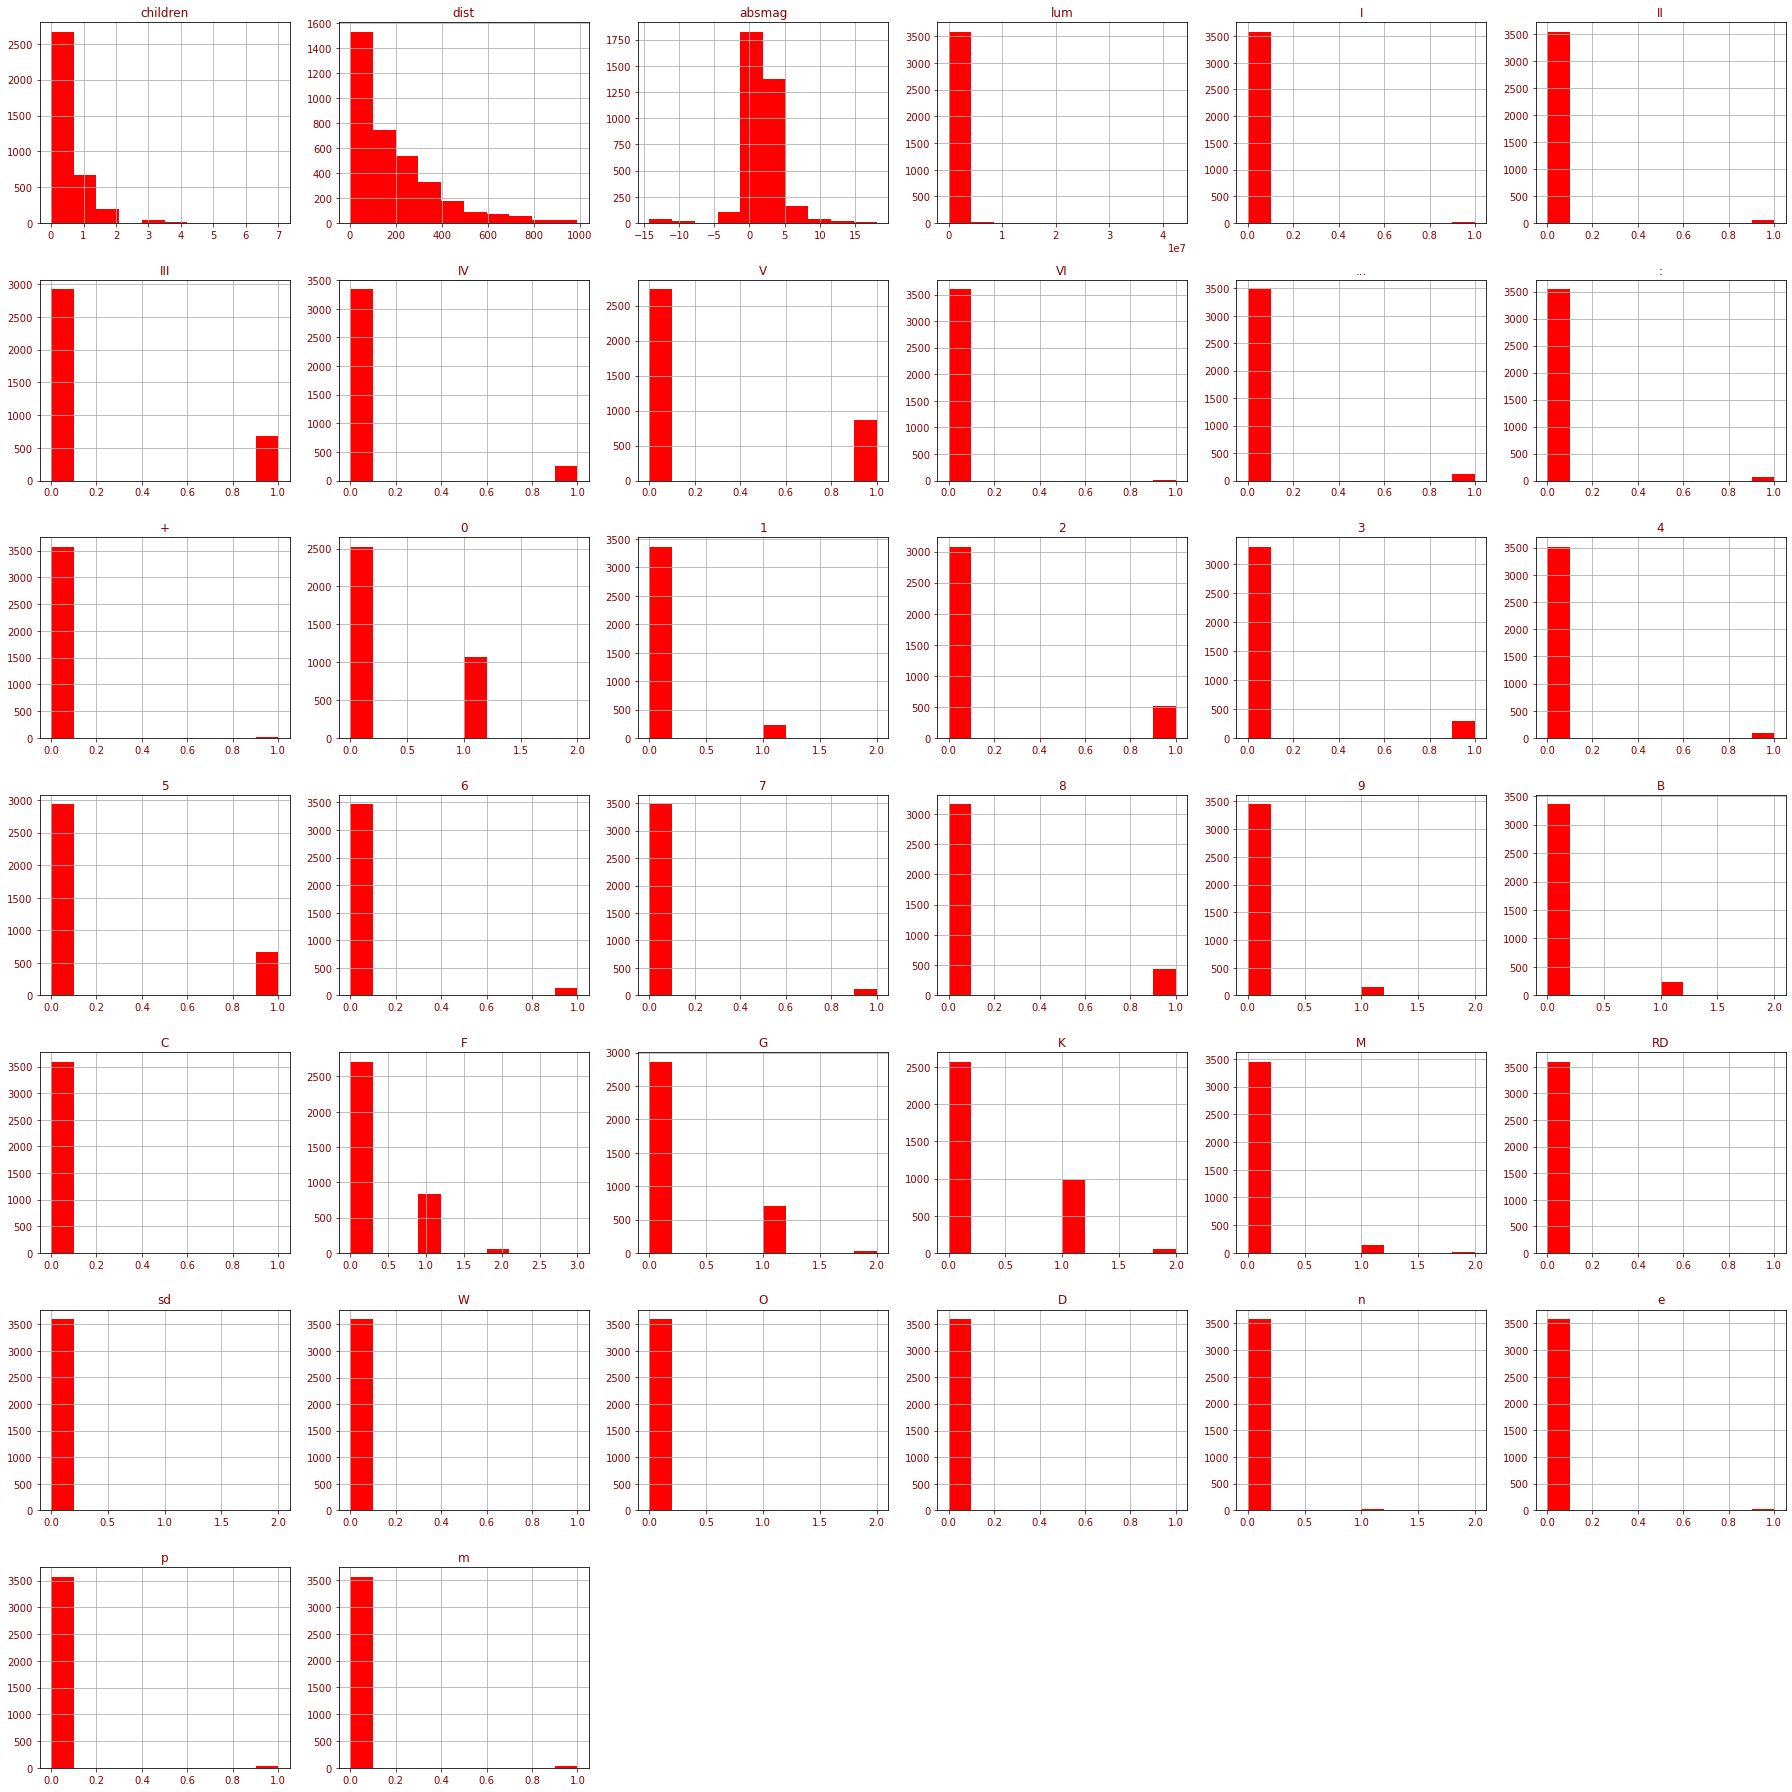

In [26]:
# Take a look at the distributions of our data, keep your eyes peeled for anything that looks off & check it out
data.hist(figsize=(25,25), color='red')
plt.show()

In [27]:
columns2norm = ['dist', 'lum', 'absmag']
for col in columns2norm:
    # Converting our continuous columns to Z scores to normalize them before modeling 
    data[col] = (data[col] - data[col].mean())/ data[col].std()

In [28]:
# After a few tests, I found that my best model is when predicting wether a star has at least one planet
# In the future I plan to, from here, try and predict the number of planets & type
data['children'] = data['children'] > 0
data['children'] = data['children'].astype(str).replace(to_replace={'True':1.0, 'False':0.0})

## Initial Model

Since I'm dealing almost entirely in binary variables, I decided logistic regression was the way to go & decided to do all of my modeling through sklearn. I did test random forest to make sure I could get replicable, similar results between the 2 models on both my testing and training sets to be sure I wasn't over fitting, but outside of getting similar results (that I couldn't improve much upon) the random forest model wasn't particularly noteworthy and I did not feel it needed to take up space. 

In [29]:
# seperating my target from my other variables
X = data.drop(['children'], 1)
y = data['children']

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# base model with few tuned parameters, just enough tweaking to run without 'max_iteration reached' error
firstlogreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear', max_iter=1000)
firstlogreg = firstlogreg.fit(X_train, y_train)

In [31]:
# making predictions with our base model 
y_hat_test = firstlogreg.predict(X_test)
y_hat_train = firstlogreg.predict(X_train)

In [32]:
# checking out how well our base model did 
printreports(y_test, y_hat_test, y_train, y_hat_train)

                                                      
               Testing Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       645
         1.0       0.98      0.98      0.98       255

    accuracy                           0.99       900
   macro avg       0.99      0.98      0.98       900
weighted avg       0.99      0.99      0.99       900

_____________________________________________________
               Training Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2021
         1.0       0.96      0.99      0.97       677

    accuracy                           0.99      2698
   macro avg       0.98      0.99      0.98      2698
weighted avg       0.99      0.99      0.99      2698

_____________________________________________________


In [33]:
# checking our base models other metrics
printscores(y_test, y_hat_test, X_test, y_train, y_hat_train, X_train, firstlogreg)

_____________________________________________________
Training Accuracy Score : 98.67%
Training Precision Score : 95.98%
Training Recall Score : 98.82%
Training F1 Score : 97.38%
_____________________________________________________
Training residual count:
0.0    2662
1.0      36
Training percentage correct: 98.6
_____________________________________________________
Testing Accuracy Score : 98.78%
Testing Precision Score : 98.03%
Testing Recall Score : 97.65%
Testing F1 Score : 97.84%
_____________________________________________________
Testing residual count:
0.0    889
1.0     11
Testing percentage correct: 98.7
_____________________________________________________
                                                     
Cross validated model accuracy:
Testing:
0.98 with a standard deviation of 0.01
Training:
0.98 with a standard deviation of 0.01
_____________________________________________________
Testing R2 Score: 0.9398084815321477
Testing R2 Score: 0.9290112606406732


## Final Model

Now that we have a base model to work off of, let's start on our final model. First, to help ease worries of over fitting since our initial results seem a bit too good, we're going to use smote to help balance out our classes

In [34]:
# Resample the minority class, in this case, our stars with planets 
sm = SMOTE(sampling_strategy='minority', random_state=74, k_neighbors=3)
# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(data.drop('children', axis=1), data['children'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = data.columns

In [35]:
X = oversampled_train.drop(['children'], 1)
y = oversampled_train['children']

# train test split the new data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
# smote did not keep our binary variables binary, so we're going to round them back into 1/0
cols = [x for x in X.columns[3:]]
for column in cols:
    oversampled_train[column] = oversampled_train[column].round(0)

In [37]:
# now instead of using our base paramaters, I built a search grid, which is going to check a whole bunch of ways to do logistic regresssion
# on our data and return us the best one to fit our new model 
finallog = getbestlogparams(X_train, y_train)
final_model = finallog.fit(X_train, y_train)

In [38]:
# make predictions from our final model 
y_hat_test = final_model.predict(X_test)
y_hat_train = final_model.predict(X_train)

In [39]:
# print our testing report from our final model 
printreports(y_test, y_hat_test, y_train, y_hat_train)

                                                      
               Testing Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       640
         1.0       0.99      1.00      0.99       693

    accuracy                           0.99      1333
   macro avg       0.99      0.99      0.99      1333
weighted avg       0.99      0.99      0.99      1333

_____________________________________________________
               Training Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2026
         1.0       0.98      1.00      0.99      1973

    accuracy                           0.99      3999
   macro avg       0.99      0.99      0.99      3999
weighted avg       0.99      0.99      0.99      3999

_____________________________________________________


In [40]:
# print our other metrics from our final model 
printscores(y_test, y_hat_test, X_test, y_train, y_hat_train, X_train, final_model)

_____________________________________________________
Training Accuracy Score : 99.11%
Training Precision Score : 98.4%
Training Recall Score : 99.85%
Training F1 Score : 99.11%
_____________________________________________________
Training residual count:
0.0    3964
1.0      35
Training percentage correct: 99.1
_____________________________________________________
Testing Accuracy Score : 99.32%
Testing Precision Score : 99.14%
Testing Recall Score : 99.57%
Testing F1 Score : 99.35%
_____________________________________________________
Testing residual count:
0.0    1324
1.0       9
Testing percentage correct: 99.3
_____________________________________________________
                                                     
Cross validated model accuracy:
Testing:
0.99 with a standard deviation of 0.00
Training:
0.99 with a standard deviation of 0.00
_____________________________________________________
Testing R2 Score: 0.972950487012987
Testing R2 Score: 0.9649850974333162


AUC: 0.9955357142857143


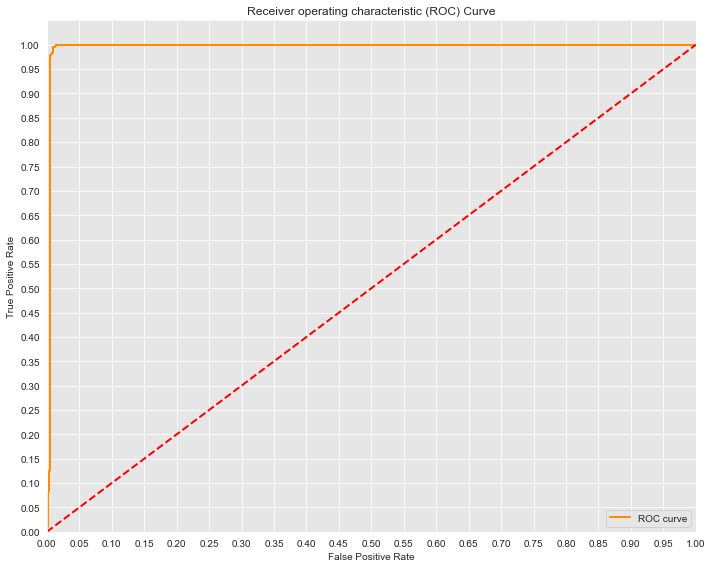

In [41]:
# calculate ROC & visualize our false positive rate 
y_score = final_model.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
show_roc_plot(fpr, tpr)

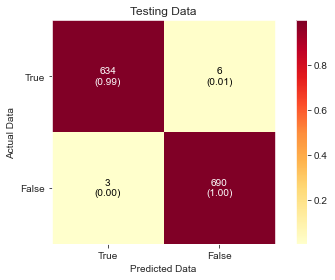

In [42]:
# visualize our confusion matricies 
showconfusionmatrix(y_test, y_hat_test, 'Testing')

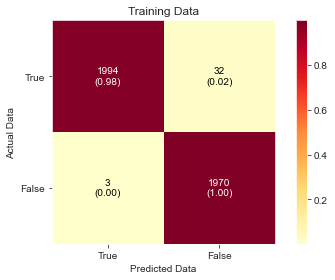

In [43]:
showconfusionmatrix(y_train, y_hat_train, 'Training')

In [44]:
# get our p scores for each of our coefficients 
p_vals = [x for x in logit_pvalue(final_model, X)]

In [45]:
np.exp(final_model.coef_)

array([[1.30373012e-25, 3.83960624e-01, 8.12958692e-01, 1.83784623e+02,
        7.36852342e-01, 1.47560083e+00, 1.34610881e-01, 6.33914977e-01,
        9.37880269e-01, 5.55652379e-01, 2.84643104e+00, 4.53237826e-01,
        8.90867660e-01, 5.27409082e-01, 8.92000555e-01, 5.83181625e-01,
        1.14312372e+00, 5.44881323e-01, 4.73492988e-01, 5.08358457e-01,
        7.84546217e-01, 5.63276679e-01, 1.12885673e+00, 6.13820228e-01,
        2.43755745e+00, 9.95790966e-01, 8.91940217e-01, 2.52310722e-01,
        1.00007590e+00, 9.37432033e-01, 1.15355879e+00, 3.04487109e+00,
        2.23582430e-02, 1.17454288e+02, 2.39208629e+01, 6.81036510e+01,
        6.83175888e-01]])

## Interpret Model

I started with the null hypothesis being that we are unable to currently predict if stars have planets through non-observation methods with any degree or metric of accuracy. While I am certain without a doubt that my star predictor will miss stars that we would otherwise miss, I feel confident in it's ability to predict the likelihood that a star has a planet as well as our ability to actually observe and confirm said planet, even if our current observation methods aren't perfect. It is currently able to predict at least 98% of stars with planets across all metrics on both our training and test data with an incredibly high r2 score, meaning it is unlikely these results are just from random chance, and a standard deviation of only .2% across across our validation checks, meaning it performs with pretty good consistency. 

In [46]:
# making a dictionary to hold our feature name, coefficient, and p_value to check em easily
coefs = final_model.coef_[0]
column_names = X.columns
dict_ = {}
for i,v in enumerate(coefs):
    dict_[i] = {}
    dict_[i]['feature'] = column_names[i]
    dict_[i]['score'] = v
    dict_[i]['P_value'] = p_vals[i]

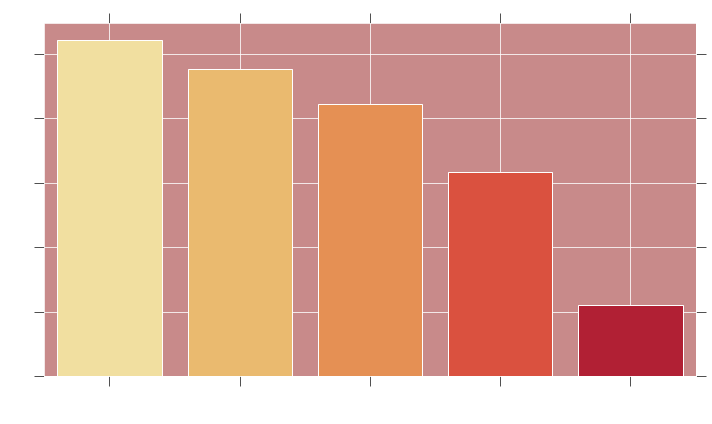

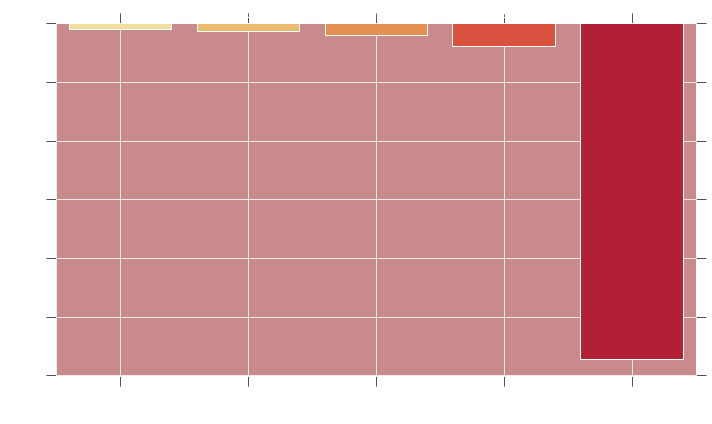

In [47]:
log_coeff = pd.DataFrame({'feature_name': column_names, 'model_coefficient': final_model.coef_.transpose().flatten()})
log_coeff = log_coeff.sort_values('model_coefficient',ascending=False)
log_coeff_top = log_coeff.head(5)
log_coeff_bottom = log_coeff.tail(5)
# Plot top 5 coefficients
plt.figure(frameon=False).set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=log_coeff_top, palette="YlOrRd")
fg3.set_xticklabels(rotation=35, labels=log_coeff_top.feature_name, fontdict={'color': 'w', 'size':10})
fg3.tick_params(which='both', reset=True, labelcolor='#FFFFFF', size=10)
fg3.set_facecolor('#C88A8A')
plt.title('5 Most Significant Positive Coefficients', fontdict={'color': 'w', 'size':15})
plt.xlabel('Feature', fontdict={'color': 'w', 'size':15})
plt.ylabel('Coefficient', fontdict={'color': 'w', 'size':15})
# Plot bottom 5 coefficients
plt.figure(frameon=False).set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=log_coeff_bottom, palette="YlOrRd")
fg4.set_xticklabels(rotation=35, labels=log_coeff_bottom.feature_name)
plt.title('5 Most Significant Negative Coefficients', fontdict={'color': 'w', 'size':15})
fg4.tick_params(which='both', reset=True, labelcolor='#FFFFFF', size=10)
fg4.set_facecolor('#C88A8A')
plt.xlabel('Feature', fontdict={'color': 'w', 'size':15})
plt.ylabel('Coefficient', fontdict={'color': 'w', 'size':15})
plt.subplots_adjust(bottom=0.4)

What our top 5 most important coeeficients are telling us:

In [48]:
print(dict_[0])

{'feature': 'dist', 'score': -57.29939784686404, 'P_value': 0.0}


for every 1 pc away from earth the likelihood we'll be able & likely to confirm a planet there decreases
by .2946%. The standard deviation of distance in pc is 193.45. 

This means distance is super relevant, despite not being a constant of stars in the same way as magnitude/temperature 
are. It's unsafe to assume that there is something special in our neighborhood causing this, as our main method of confirming exoplanets is direct observation, and it does undoubtedly get more difficult to view small dips in stars light precisely the farther away they are due to red shifting, gravitational lensing & the limits of our current telescope technology, to name a few reasons. 
This doesn't mean that distance is an irrelevant factor in exoplanet discovery, my interpretation of this coefficient is that it tells us the typical range we're currently good at confirming exoplanets in, it's likely to change over time to adjust to how advanced our telescopes get, but for now, I recommend focusing our cameras well within this range & collecting as much data as possible to train our models more and more as we push further out into the galaxy & eventually the rest of the universe with planet discovery. With a P value of .00, it is safe to say that this is incredibly statistically significant factor in our model. 

In [49]:
print(dict_[3])

{'feature': 'I', 'score': 5.213764547363541, 'P_value': 0.0026551654016284676}


I is the largest and typically brightest variety of star, supergiants, though it is very common for them to be 
large enough to have expelled their exoplanets by this stage in their lifetime, the ones that do have them are in one of the largest classes. There may be a number of reasons for this to be so positively influential on discovery, such as size, brightness & composition. With a P value of .002, it is safe to say that this is a statistically significant factor in our model. 

In [50]:
print(dict_[35])

{'feature': 'p', 'score': 4.2210308237011995, 'P_value': 0.011491593824485946}


In astrophysics, chemically peculiar (p) stars are stars with distinctly unusual metal abundances,
at least in their surface layers. These stars have been positively associated with the ability to predict exoplanet discovery in our model, though it makes no predictions as to what the peculiarities role plays & I am unable to draw further conclusions. With a P value of .01, it is safe to say that this is a statistically significant factor in our model. 

In [51]:
print(dict_[34])

{'feature': 'e', 'score': 3.174751003795955, 'P_value': 0.8353548770852466}


e 
emission lines indicate that a star is at a particular temperature range & composition to emit visible 
element lines, unfortunately though it is a star feature that has been associated with a positive influence on our ability to predict a planet there in terms of coefficients, with a P value of .83 it is safe to say it is not statistically significant. 

In [52]:
print(dict_[33])

{'feature': 'n', 'score': 4.766049218227404, 'P_value': 0.8214271344268862}


n indicated a spectral class with broad ("nebulous") absorption due to spinning, unfortunately though it is a star feature that has been associated with a positive influence on our ability to predict a planet there in terms of coefficients, with a P value of .82 it is safe to say it is not statistically significant. 

In [53]:
print(dict_[1]) 

{'feature': 'absmag', 'score': -0.9572152741204397, 'P_value': 0.0}


Though the coefficients aren't as high per unit change of our continuous variables as they are for our binary variables, when you factor in a range of over 50+ for absolute magnitude can have a change of almost 10 in either direction, making it, in many cases, the second highest contributor to whether a planet is predicted or not, even if most stars in middle magnitudes see little or no change. I did also find statistically significant findings in terms of P value when it comes to whether or not we're more likely to predict planets around stars with higher or lower magnitudes. My data in this category is normalized to it's z score, so for each standard deviation away from the mean magnitude it represents a change of -.95% in our likelihood of confirming a planet there if we looked with our current metrics, which I will break down further in the recommendations. Despite the change not being huge for most stars, we have still observed pretty noticeable amount more planets directed around really bright stars (which have lower magnitudes). 

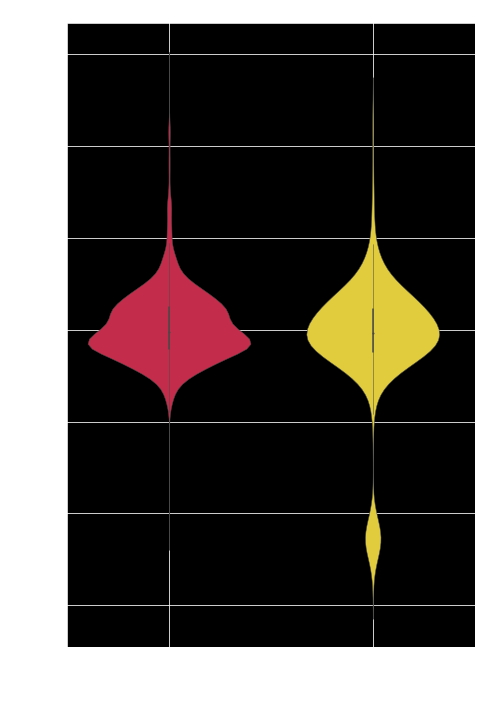

In [54]:
fig = plt.figure(figsize=(7,10), frameon=False)
sns.violinplot(data=data, x='children', y='absmag', split=True, linewidth=.5, palette=['#DC143C', '#FBE122'], figure=fig)
plt.xlabel('Planets Predicted', labelpad=16, fontdict={'color': 'w', 'size':15})
plt.ylabel('Absolute Magnitude', labelpad=16, fontdict={'color': 'w', 'size':15})
plt.title("Predictions Of Planets", fontdict={'color': 'w', 'size':15})
ax = plt.gca()
ax.tick_params(which='both', reset=True, labelcolor='#FFFFFF', size=15, color='#FFFFFF')
plt.xticks(ticks=[0,1], labels=['No Planet', 'Has Planet'])
ax.set_facecolor('#000000')
plt.show()

## Star Predictor 
Now that I feel pretty confident about how our model handles our dataset, I want to make some specific predictions based on star id's or names, since the spectral type's can be written in too many ways for my knowledge level with coding to know how to parse through, for now, it'll ask you some questions about your star type before making a descision and returning your star to you. 

In [55]:
star_csv = pd.read_csv('data/hygdata_v3.csv')
scrubbed = pd.read_csv('scrubbed.csv')

In [56]:
print(f'Our dataset currently contains {star_csv.shape[0]} predictable stars')
print(f'Here is a random star to test if you do not have one in mind: {randrange(star_csv.shape[0])}')

Our dataset currently contains 119614 predictable stars
Here is a random star to test if you do not have one in mind: 83976


In [57]:
star = predict_a_star(star_csv.loc[1070])

Your star type is: F5IV/V
_____________________________________________________________________________________________
                     
Please answer a few questions to help the program understand your star type.
_____________________________________________________________________________________________
                     
Does the type contain any capitalized letters? Please list all applicable seperated by spaces.
Please do not include roman numerals, we will handle those seperatly.


 f


_____________________________________________________________________________________________
                 
Does it contain numbers? Please list all applicable seperated by spaces


 5


_____________________________________________________________________________________________
                 
Does it contain roman numerals? Please list all applicable seperated by spaces


 iv


_____________________________________________________________________________________________
                 
Does it contain any lowcase letters? Please list all applicable seperated by spaces.


_____________________________________________________________________________________________
                     
Does it contain any special symbols? Please list all applicable seperated by spaces.
Please substitute 1 in place of "...", 2 in place of "+", and 3  in place of ":"


Thank you for answering.
 
Your star, HD 899.0 is likely to have a planet. :)


## 3d visuals

In order to plot our data on a map of the milky way so that we have some context for our stars, we have to convert them to astropy coordinates & pass those as parameters to a module that will plot the Mily Way for us. I also checked some stars by name against published maps of the Milky Way to be sure my positioning was as correct as it could be, given the images won't feature the stars to scale.

In [58]:
sun = star_csv.loc[0]
sunra = Longitude(sun['ra'], unit=u.deg)
sundec = np.array(sun['dec']) * u.deg
sundist = np.array(sun['dist']) * u.pc

s =  SkyCoord(ra=sunra, dec=sundec, distance=sundist, obstime='2001-01-01T12:00:00')

In [59]:
star_csv = star_csv.loc[star_csv['rv'] > 0]

In [60]:
scrubbed = scrubbed.loc[scrubbed['children'] > 0]
ra = Longitude(scrubbed['ra'], unit=u.deg)
dec = np.array(scrubbed['dec']) * u.deg
distance = np.array(scrubbed['dist']) * u.pc
mag = np.array(scrubbed['absmag']) * u.mag
rv = np.array(scrubbed['rv']) * u.km/u.s
pmra = np.array(scrubbed['pmrarad']) * u.mas/u.yr
pmdec = np.array(scrubbed['pmdecrad']) * u.mas/u.yr

p = SkyCoord(ra=ra, dec=dec, distance=distance, obstime='2001-01-01T12:00:00', pm_ra_cosdec= pmra, pm_dec=pmdec, 
             equinox='J2000.0')

In [61]:
ra = Longitude(star_csv['ra'], unit=u.deg)
dec = np.array(star_csv['dec']) * u.deg
distance = np.array(star_csv['dist']) * u.pc
mag = np.array(star_csv['absmag']) * u.mag
rv = np.array(star_csv['rv']) * u.km/u.s
pmra = np.array(star_csv['pmrarad']) * u.mas/u.yr
pmdec = np.array(star_csv['pmdecrad']) * u.mas/u.yr

c = SkyCoord(ra=ra, dec=dec, distance=distance, obstime='2001-01-01T12:00:00', pm_ra_cosdec= pmra, pm_dec=pmdec, 
             equinox='J2000.0', frame=ICRS) 

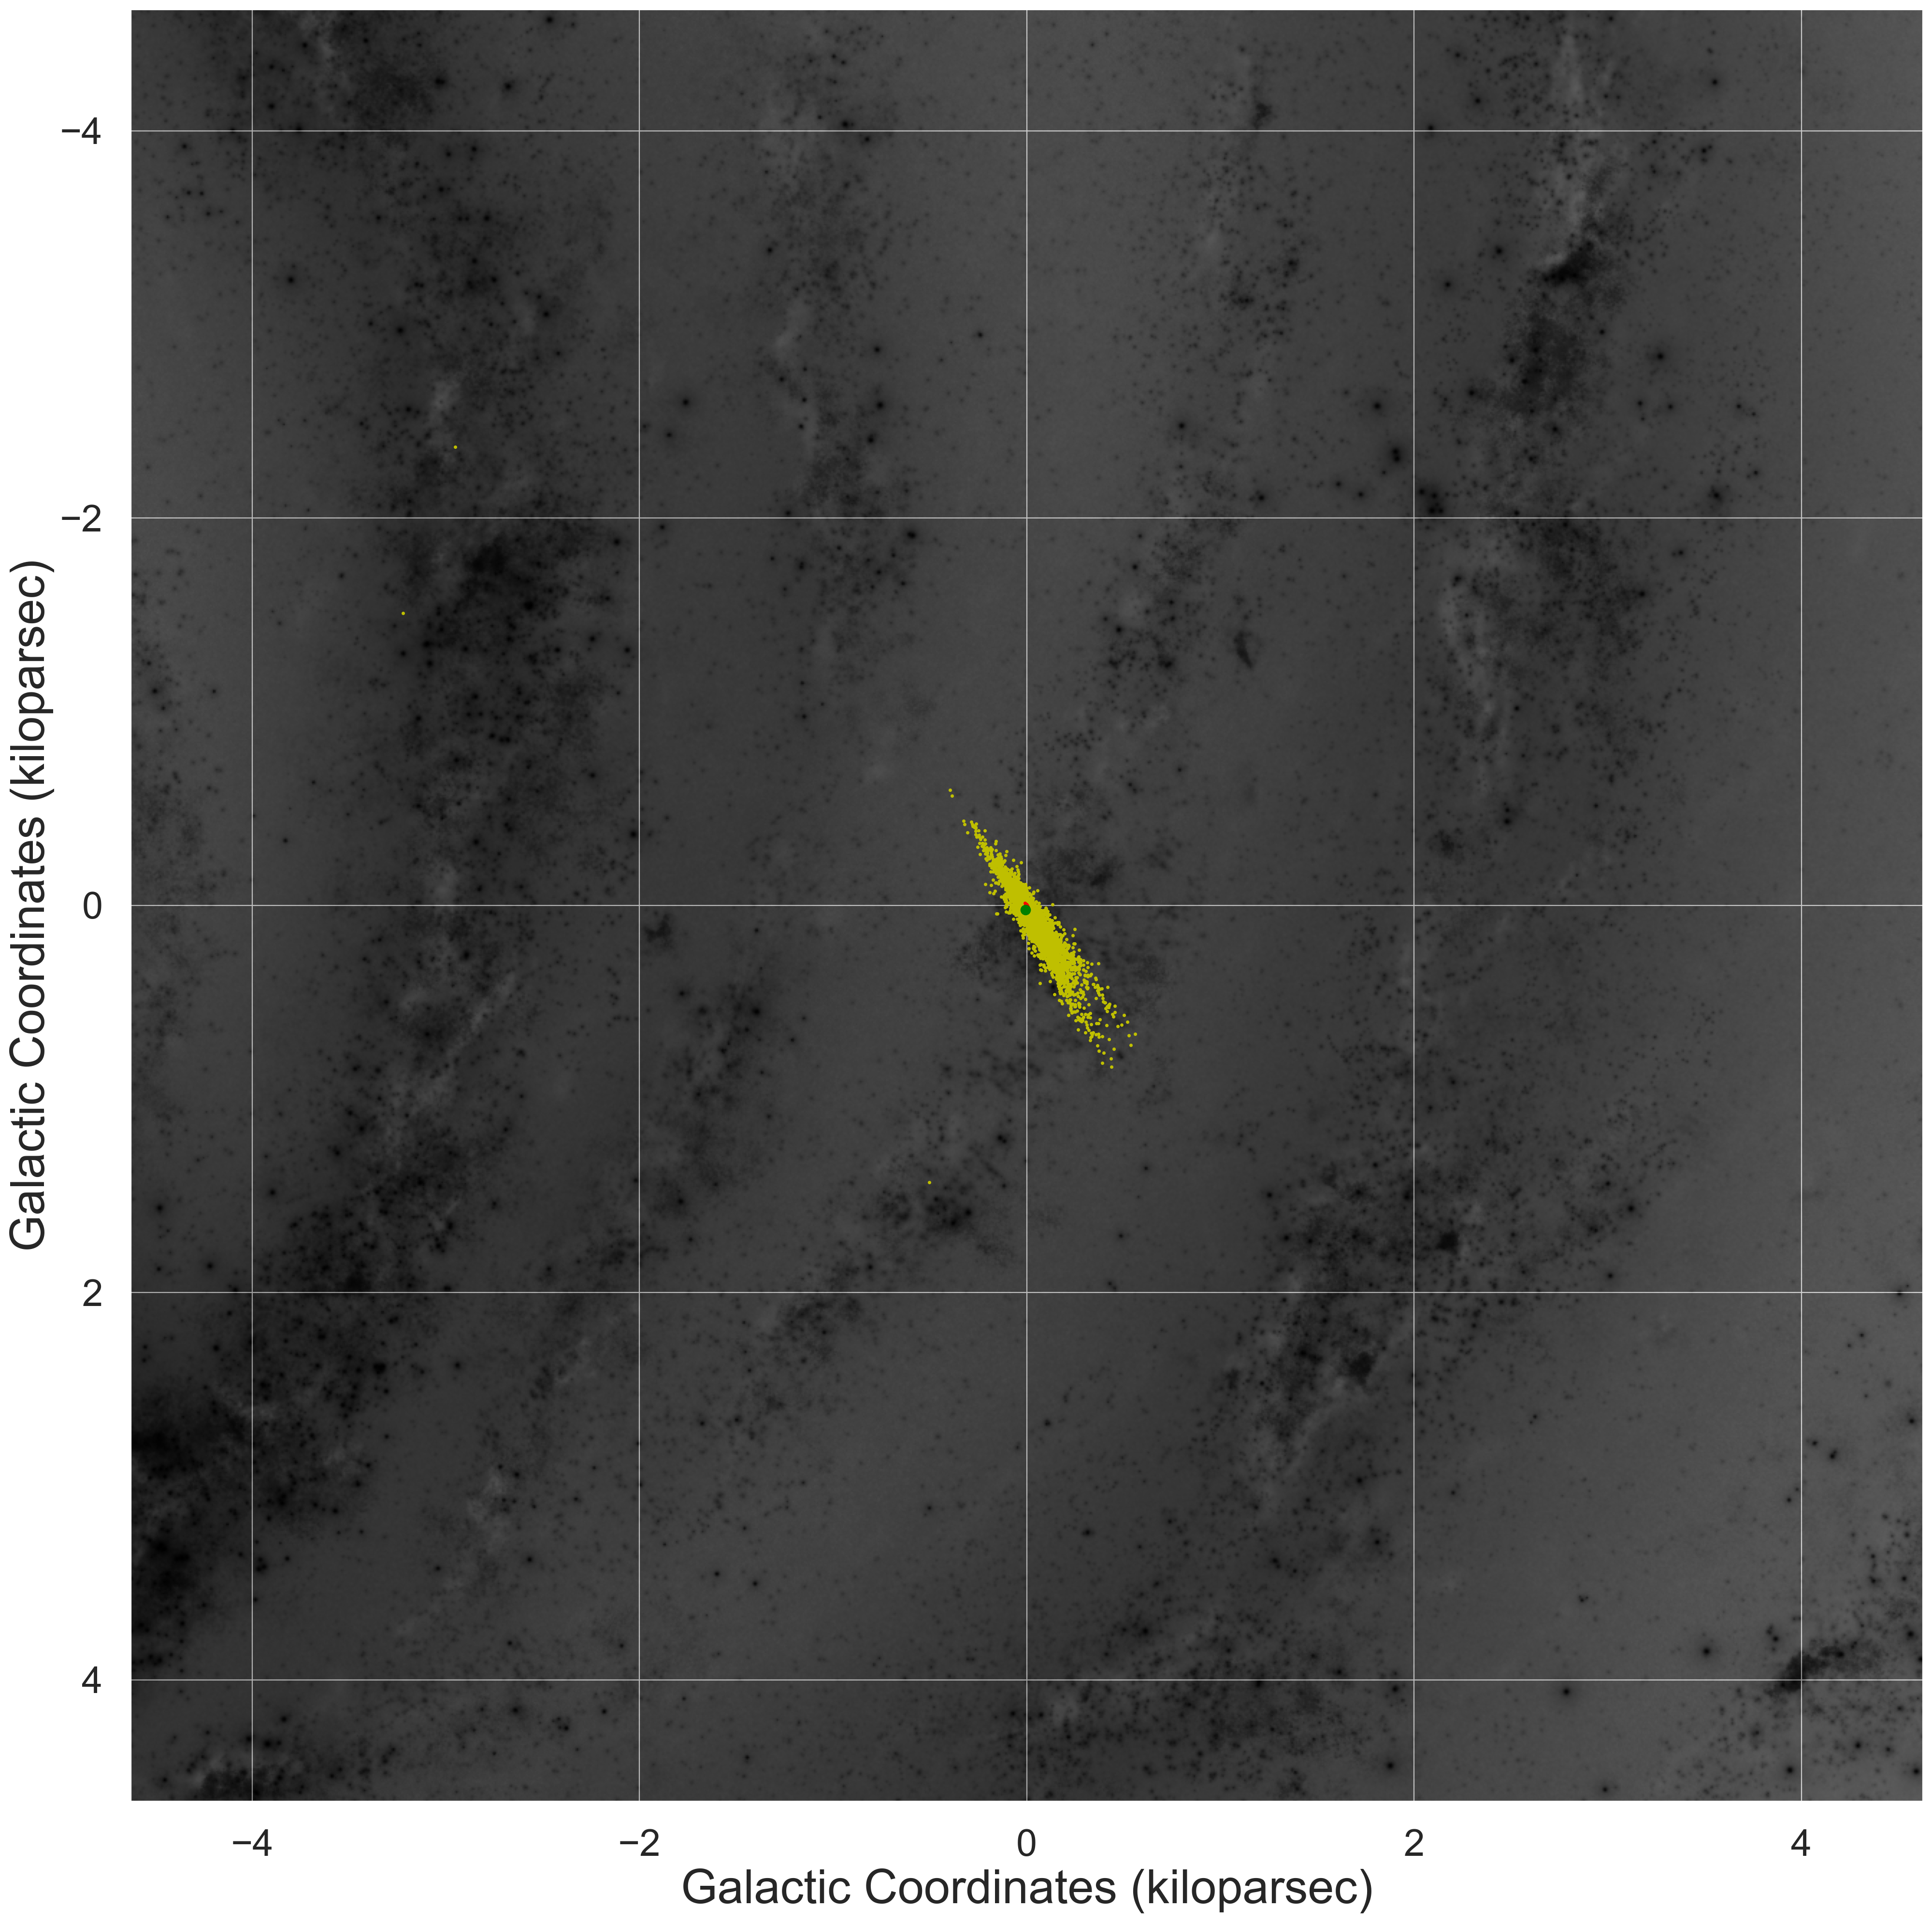

In [62]:
showstar(star_csv.loc[39], 'out')

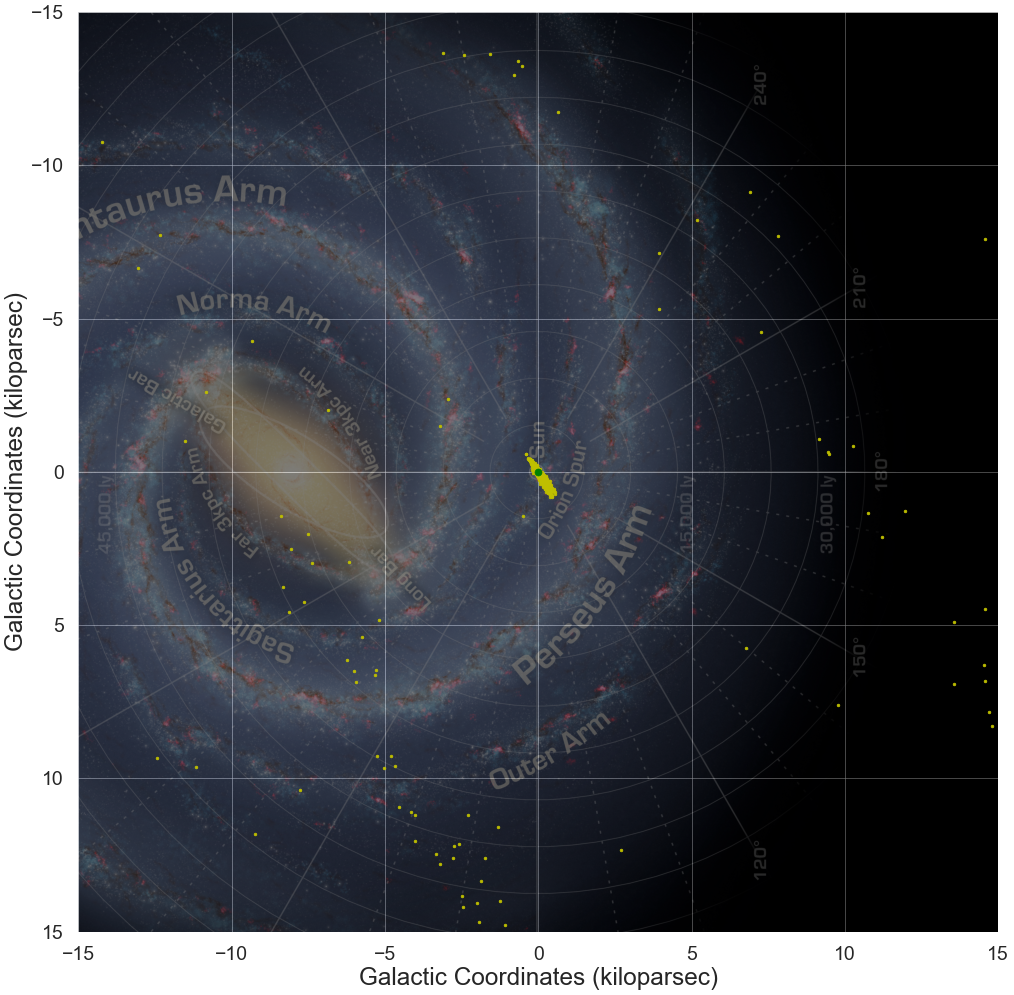

In [63]:
plotall(15, True, False, 50, .5, 15, 25, 100)

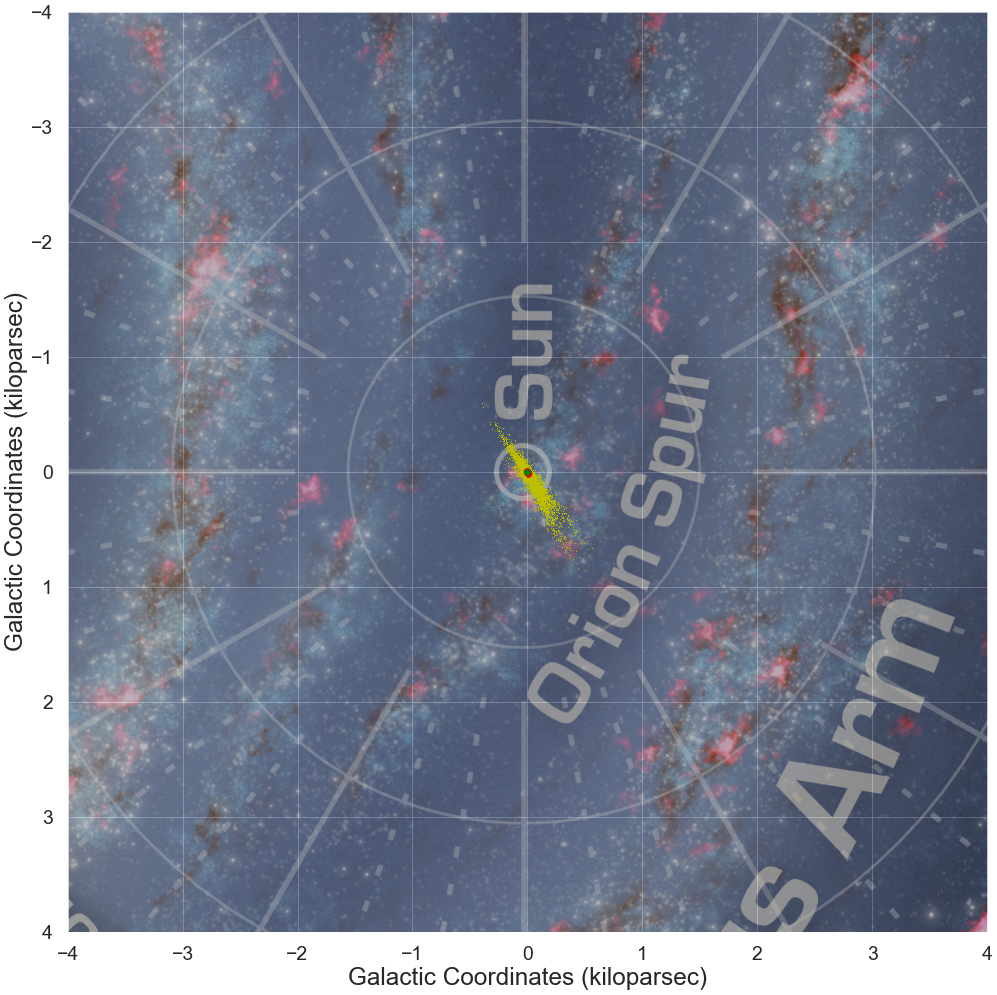

In [64]:
plotall(4, True, False, 50, .75, .5, 50, 75)

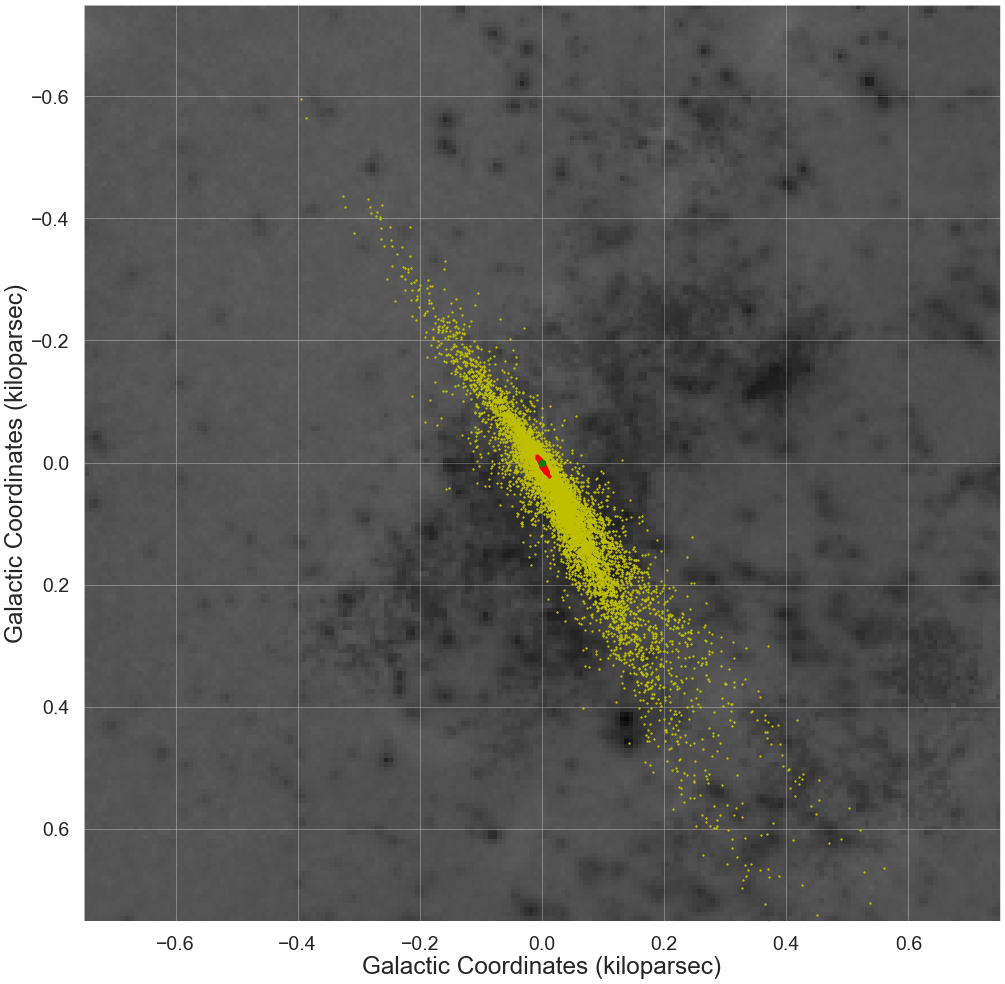

In [65]:
plotall(.75, False, True, 50, .65, 5, 25, 100)

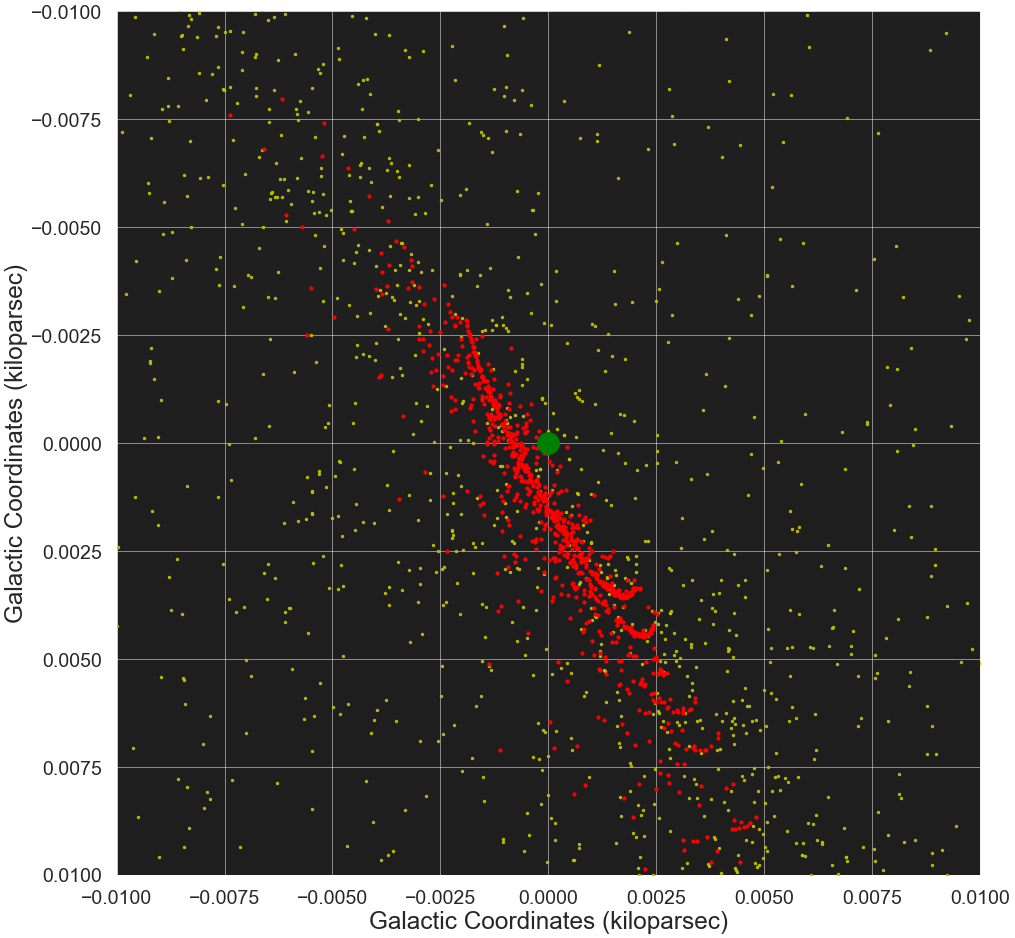

In [66]:
plotall(.01, False, True, 50, .25, 15, 25, 1000)

# Recommendations:

Use simple machine learning based off of information we already have available about stars to make reasonable predictions for which stars are likely to have planets we can detect & use those predictions to save time between discoveries by cutting down on the number of hours our telescopes are observing changes in the light output in stars unlikely to have exoplanets. 

Look within a few hundred light years/dozen pc, and venture further out as we get more data that helps us make more accurate predictions farther away with less direct observation data. With distance being our most important factor, it's important to recognize that it's not been proven that this is due to our part of the galactic neighborhood being inherently different, & we're well aware of the struggles we have seeing at large distances. This doesn't mean we should give up on searching until we have the perfect telescope & can definitively prove one way or the other, searching within just the closest 100 light years there are an estimated 14,600 stars, and at a distance of only 30pc, our model is still above 90% in every metric. 

Focus on the stars with the brightest absolute magnitudes, though glare from the star may make directly observing transits more difficult, I believe that the statistical significance of absolute magnitude might suggest that other detection methods, such as light curves, or using a combination of methods may be more valuable than we tend to give them credit for when it comes to exoplanet discovery. The standard deviation for absolute magnitude is 2.85 & our data was normalized using z scoring, so for every 1 unit change in absolute magnitude (dimmer) a star gets, it's -0.34% less likely for us to predict a planet around it.

# Conclusion 

I believe I have effectively demonstrated that machine learning, even in some of the simplest forms, has gotten advanced enough that with the amount of confirmed exo-planet discoveries we now have we can start using it to make predictions for us & help us save time on the hunt for more. 

## Thank you